# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [1]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

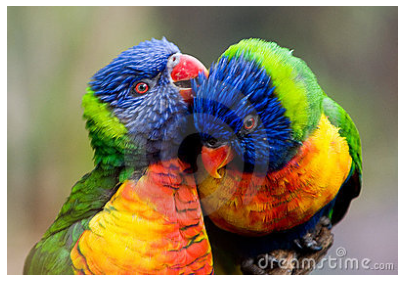

In [3]:
img = cv2.imread('birds.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [4]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [5]:
from skimage.metrics import structural_similarity
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import numpy as np
import pandas as pd

In [6]:
img_flatten = img.reshape((img.shape[0]*img.shape[1], 3))

Для начала попробуем кластеризацию методом KMeans.

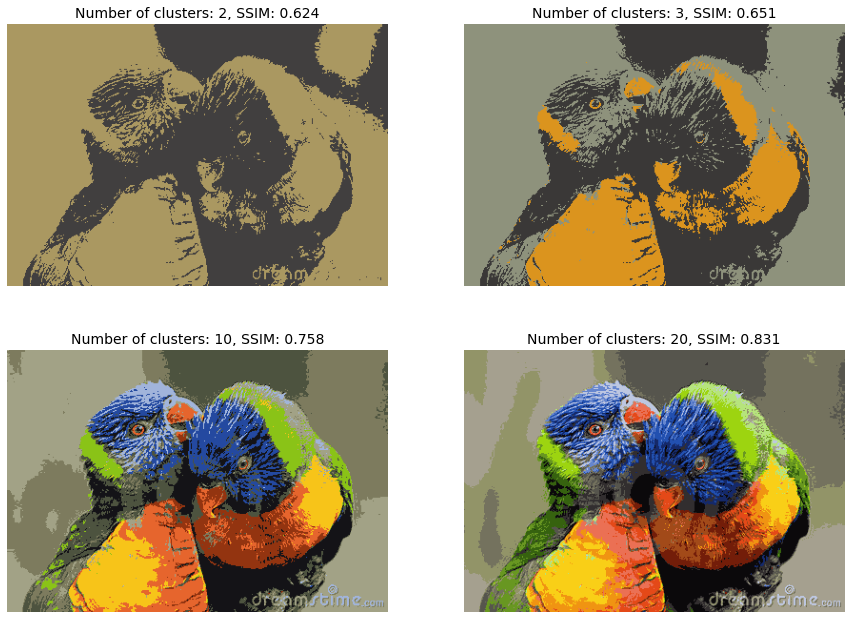

In [59]:
cls = [2, 3, 10, 20]
fig, axs = plt.subplots(2, 2, figsize=(15, 11))
plt.axis('off')
for cl, ax in zip(cls, axs.flatten()):
    ax.axis("off")
    kmeans = KMeans(n_clusters=cl)
    clusters = kmeans.fit_predict(img_flatten)
    img_reduced = kmeans.cluster_centers_[clusters].reshape((img.shape[0], img.shape[1], 3))
    b, g, r = cv2.split(img_reduced/255)
    new_image = cv2.merge([r, g, b])
    ax.imshow(new_image)
    ssim = structural_similarity(img/255, img_reduced/255, multichannel=True)
    ax.set_title(f"Number of clusters: {cl}, SSIM: {ssim:.03}", size=14)
plt.show()

Видно, что алгоритм справился достаточно неплохо, как и ожидалось, с ростом количества кластеров изображение все больше похоже на оригинал, о чем говорит и метрика SSIM.

При попытке использовать агломеративную кластеризацию была получена MemoryError, алгоритму для работы нужен большой объем памяти, поэтому на достаточно большом объеме данных, таком как изображение, он неэффективен.

Попробуем использовать DBSCAN, для начала переберем максимальное расстояние между точками в кластере.

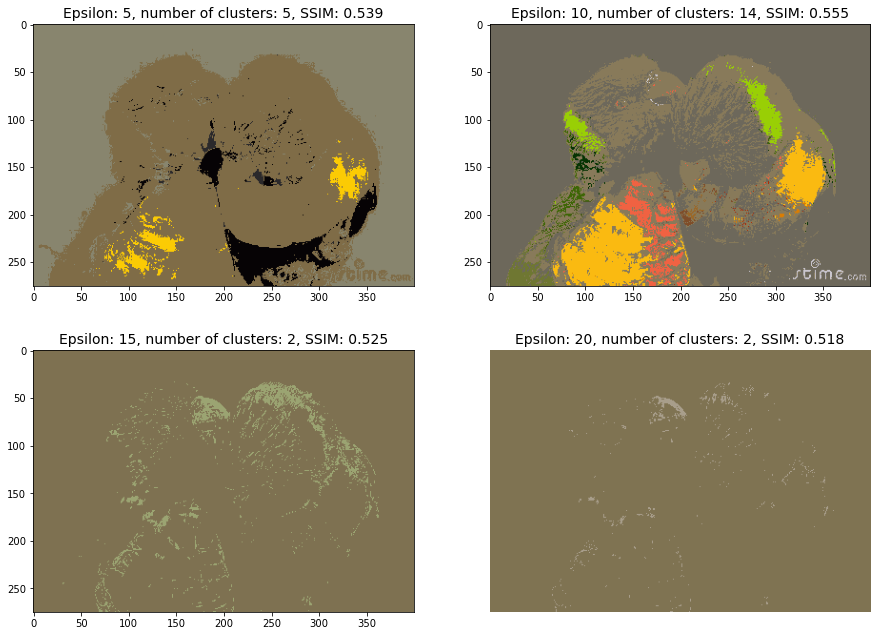

In [137]:
epsilons = [5, 10, 15, 20]
fig, axs = plt.subplots(2, 2, figsize=(15, 11))
plt.axis('off')
for eps, ax in zip(epsilons, axs.flatten()):
    dbscan = DBSCAN(eps=eps, min_samples=100)
    clusters = dbscan.fit_predict(img_flatten)
    cl = len(set(clusters))
    df = pd.DataFrame({"r": img_flatten[:, 0], "g": img_flatten[:, 1], "b": img_flatten[:, 2],
                       "clusters": clusters})
    r = df.groupby("clusters")["r"].mean()
    g = df.groupby("clusters")["g"].mean()
    b = df.groupby("clusters")["b"].mean()
    img_reduced = np.vstack((r[clusters], g[clusters], b[clusters])).T
    img_reduced = img_reduced.reshape((img.shape[0], img.shape[1], 3))
    b, g, r = cv2.split(img_reduced/255)
    new_image = cv2.merge([r, g, b])
    ax.imshow(new_image)
    ssim = structural_similarity(img/255, img_reduced/255, multichannel=True)
    ax.set_title(f"Epsilon: {eps}, number of clusters: {cl}, SSIM: {ssim:.03}", size=14)
plt.show()

Теперь для наилучшего результата (epsilon = 10), переберем минимальное количество точек в кластере.

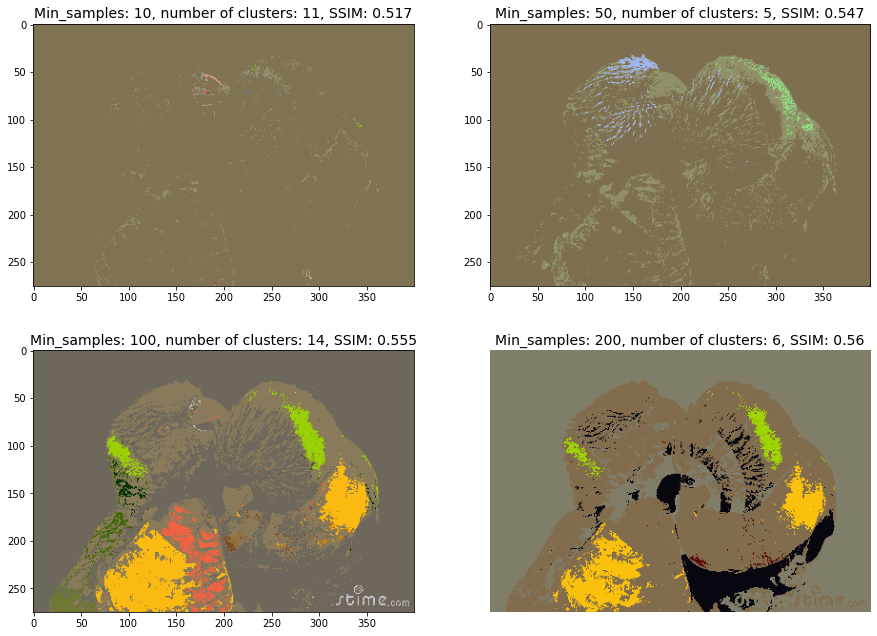

In [138]:
min_s = [10, 50, 100, 200]
fig, axs = plt.subplots(2, 2, figsize=(15, 11))
plt.axis('off')
for s, ax in zip(min_s, axs.flatten()):
    dbscan = DBSCAN(eps=10, min_samples=s)
    clusters = dbscan.fit_predict(img_flatten)
    cl = len(set(clusters))
    df = pd.DataFrame({"r": img_flatten[:, 0], "g": img_flatten[:, 1], "b": img_flatten[:, 2],
                       "clusters": clusters})
    r = df.groupby("clusters")["r"].mean()
    g = df.groupby("clusters")["g"].mean()
    b = df.groupby("clusters")["b"].mean()
    img_reduced = np.vstack((r[clusters], g[clusters], b[clusters])).T
    img_reduced = img_reduced.reshape((img.shape[0], img.shape[1], 3))
    b, g, r = cv2.split(img_reduced/255)
    new_image = cv2.merge([r, g, b])
    ax.imshow(new_image)
    ssim = structural_similarity(img/255, img_reduced/255, multichannel=True)
    ax.set_title(f"Min_samples: {s}, number of clusters: {cl}, SSIM: {ssim:.03}", size=14)
plt.show()

Как видно, алгоритм справился со своей задачей сильно хуже, чем Kmeans, он также неудобен тем, что нужно подбирать 2 гиперпараметра, при этом сложно заранее сказать, как то или иное изменение повлияет на результат.
В Kmeans гиперпараметр только один - количество кластеров, и близость полученного изображения прямо пропорционально количеству выделяемых кластеров цветов.

Применим Kmeans на моих фотографиях.

Ссылки: [forest.jpg](https://drive.google.com/file/d/1sNQGQoWpD6wMyIrAJUbJRDP4WR5JLrgr/view?usp=), ["river.jpg"](https://drive.google.com/file/d/1TpzZJcZUStDd-SQOCU6UMoOL2zqhaieX/view?usp=sharing)

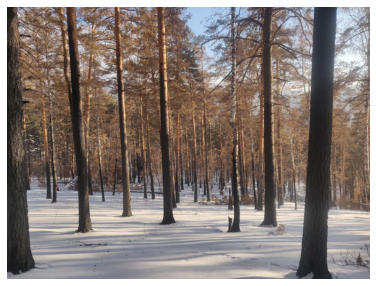

In [139]:
img = cv2.imread("forest.jpg")
img_flatten = img.reshape((img.shape[0]*img.shape[1], 3))
draw_picture(img)

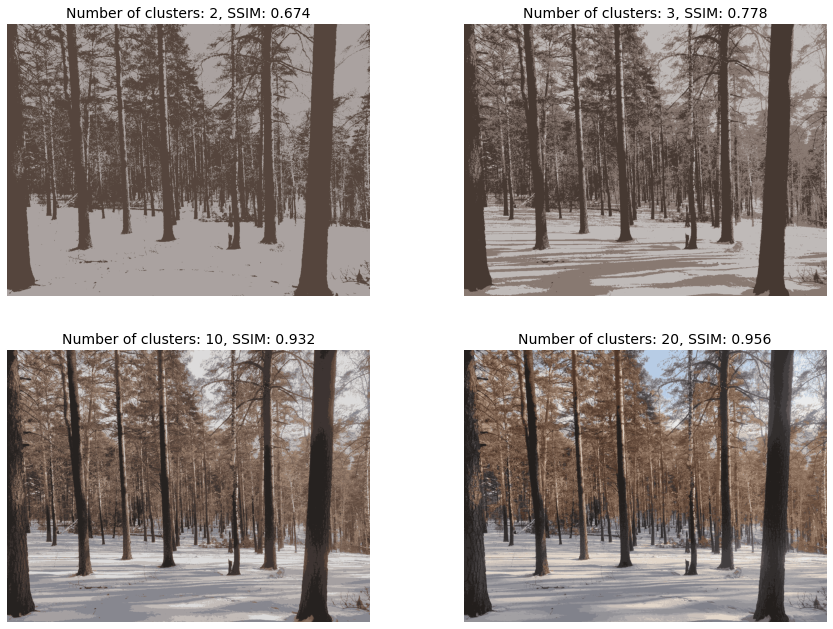

In [140]:
cls = [2, 3, 10, 20]
fig, axs = plt.subplots(2, 2, figsize=(15, 11))
plt.axis('off')
for cl, ax in zip(cls, axs.flatten()):
    ax.axis("off")
    kmeans = KMeans(n_clusters=cl)
    clusters = kmeans.fit_predict(img_flatten)
    img_reduced = kmeans.cluster_centers_[clusters].reshape((img.shape[0], img.shape[1], 3))
    b, g, r = cv2.split(img_reduced/255)
    new_image = cv2.merge([r, g, b])
    ax.imshow(new_image)
    ssim = structural_similarity(img/255, img_reduced/255, multichannel=True)
    ax.set_title(f"Number of clusters: {cl}, SSIM: {ssim:.03}", size=14)
plt.show()

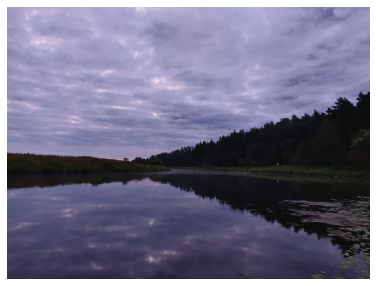

In [141]:
img = cv2.imread("river.jpg")
img_flatten = img.reshape((img.shape[0]*img.shape[1], 3))
draw_picture(img)

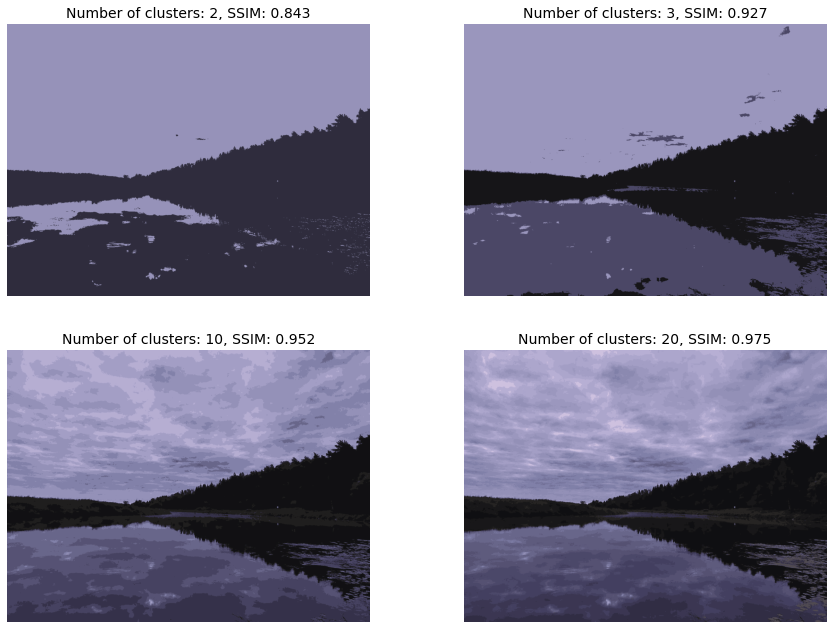

In [142]:
cls = [2, 3, 10, 20]
fig, axs = plt.subplots(2, 2, figsize=(15, 11))
plt.axis('off')
for cl, ax in zip(cls, axs.flatten()):
    ax.axis("off")
    kmeans = KMeans(n_clusters=cl)
    clusters = kmeans.fit_predict(img_flatten)
    img_reduced = kmeans.cluster_centers_[clusters].reshape((img.shape[0], img.shape[1], 3))
    b, g, r = cv2.split(img_reduced/255)
    new_image = cv2.merge([r, g, b])
    ax.imshow(new_image)
    ssim = structural_similarity(img/255, img_reduced/255, multichannel=True)
    ax.set_title(f"Number of clusters: {cl}, SSIM: {ssim:.03}", size=14)
plt.show()

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [2]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [3]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [5]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [6]:
y.shape

(2370,)

In [7]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

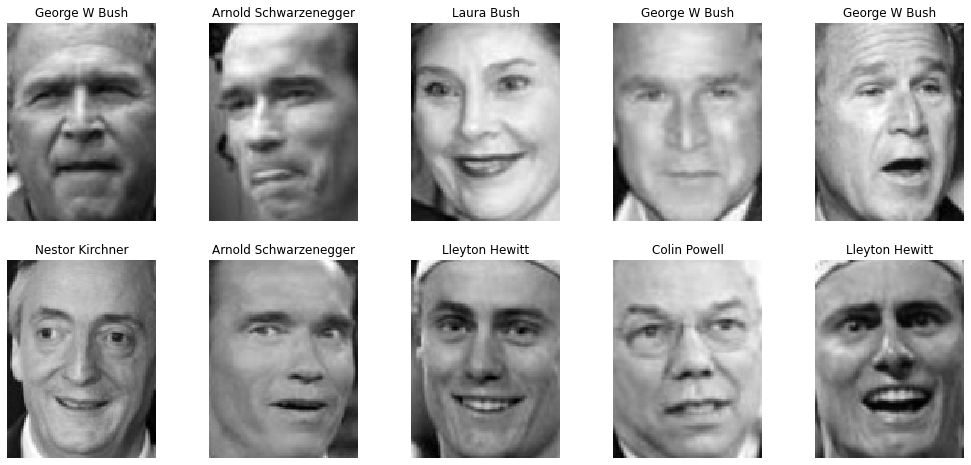

In [8]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
from collections import Counter
import numpy as np

Для начала обучим логистическую регрессию на полном наборе данных. Также посмотрим, на точность предсказания тестового набора данных самым распространенным классом в трэйне.

In [10]:
start = time.time()
logreg = LogisticRegression().fit(X_train, y_train)
pred = logreg.predict(X_test)
result_time = time.time() - start
print(f"Отработало за: {result_time:.03} секунд")

Отработало за: 18.6 секунд


In [11]:
accuracy_score(pred, y_test)

0.6729957805907173

In [29]:
sorted_y = [i for i in sorted(Counter(y_train).items(), key=lambda x: x[1])]
y_maxs = [i[0] for i in sorted_y[-10:]]
y_max = y_maxs[-1]
const_pred = np.full(y_test.shape, y_max)
print(accuracy_score(const_pred, y_test))

0.23839662447257384


Видно, что регрессия справляется сильно лучше константного предсказания.

Применим к данным PCA и t-SNE и визуализируем результат для 10 самых распространенных классов.

In [12]:
X_pca = PCA(n_components=5).fit_transform(X)

In [13]:
X_tsne = TSNE(n_iter=3000, n_components=2).fit_transform(X)

In [18]:
sorted_y = [i for i in sorted(Counter(y).items(), key=lambda x: x[1])]
y_maxs = [i[0] for i in sorted_y[-10:]]

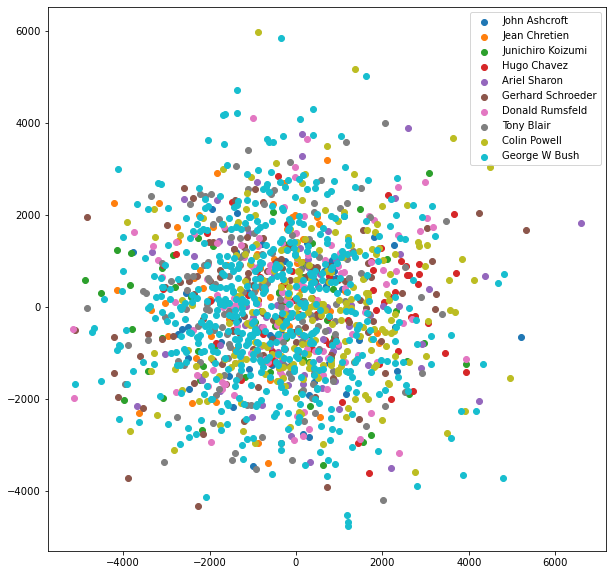

In [16]:
plt.figure(figsize=(10, 10))
for i in y_maxs:
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=names[i])
plt.legend()
plt.show()

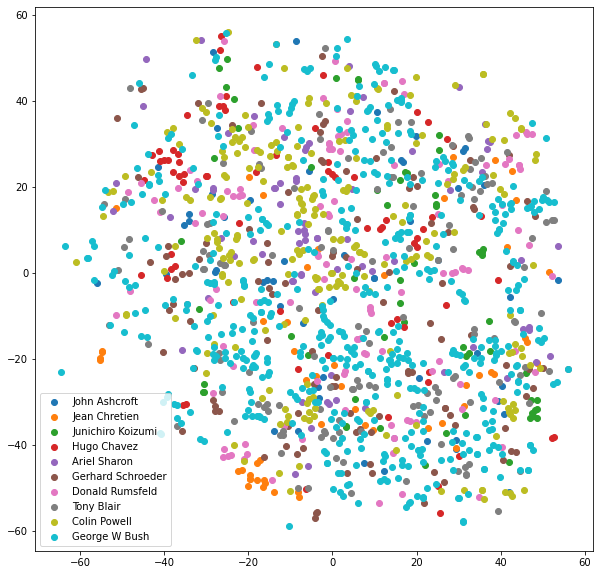

In [50]:
plt.figure(figsize=(10, 10))
for i in y_maxs:
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], label=names[i])
plt.legend()
plt.show()

Видно что по первым 2 компонентам PCA данные не разделяются. В результате t-SNE можно видеть, что образуются отдельные группы объектов, принадлежащих одному классу, однако никакого явного разделения не происходит.

Попробуем использовать результаты алгоритмов уменьшения размерности для предсказания.

In [17]:
pca = PCA(n_components=6).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [51]:
tsne = TSNE(n_iter=1000, n_components=2)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

In [55]:
start = time.time()
logreg = LogisticRegression().fit(X_train_tsne, y_train)
pred = logreg.predict(X_test_tsne)
result_time = time.time() - start
print(f"Отработало за: {result_time:.03} секунд")

Отработало за: 0.173 секунд


In [56]:
accuracy_score(pred, y_test)

0.23839662447257384

Видно, что скорость работы сильно вырасла при сжатии до 2 фичей при помощи t-SNE, однако произошла катастрофическая просадка в качестве до уровня константого предсказания.

In [61]:
scores = []
times = []
for n_comp in range(2, 7):
    start = time.time()
    logreg = LogisticRegression().fit(X_train_pca[:, :n_comp], y_train)
    pred = logreg.predict(X_test_pca[:, :n_comp])
    result_time = time.time() - start
    times.append(result_time)
    scores.append(accuracy_score(pred, y_test))

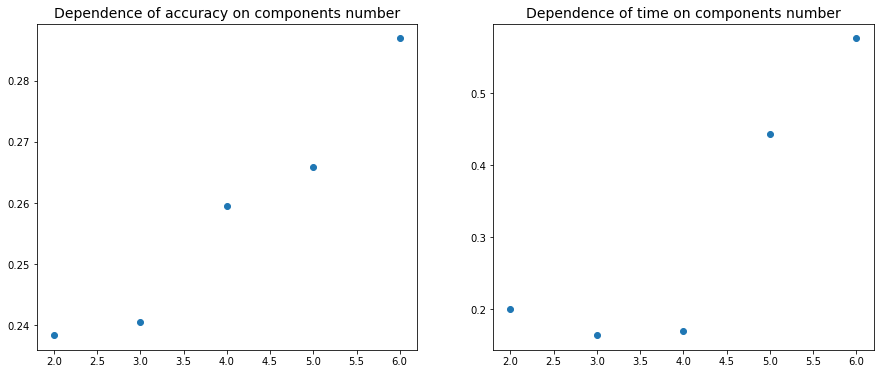

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(x=np.arange(2, 7), y=scores)
axs[0].set_title("Dependence of accuracy on components number", size=14)
axs[1].scatter(x=np.arange(2, 7), y=times)
axs[1].set_title("Dependence of time on components number", size=14)
plt.show()

PCA при n_components больше 6 работает слишком долго, у меня так и не досчитался. Видно, что с ростом числа компонент происходит значительный рост accuracy, возможно при сильно большем числе компонент (которое все же будет сильно меньше полного числа фичей) получится добится достаточно высокого accuracy при значимом снижении времени работы.

Переберем коэффициент регуляризации регрессии.

In [30]:
cs = [0.1, 0.2, 0.3, 0.5, 0.8, 1, 2, 5, 7, 10]
scores = []
for c in cs:
    logreg = LogisticRegression(C=c).fit(X_train, y_train)
    pred = logreg.predict(X_test)
    scores.append((c, accuracy_score(pred, y_test)))

In [32]:
max(scores, key=lambda x: x[1])

(0.1, 0.70042194092827)

In [10]:
logreg = LogisticRegression(penalty="none").fit(X_train, y_train)
pred = logreg.predict(X_test)
print(accuracy_score(pred, y_test))

0.6877637130801688


Как видно, лучший результат получается при коэффициенте равном 0.1, обучим модель при нем.

In [11]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred = logreg.predict(X_test)
print(accuracy_score(pred, y_test))

0.70042194092827


Посмотрим на 3 ошибки полученной модели.

In [51]:
first_true, first_false = y_test[pred != y_test][0], pred[pred != y_test][0]
second_true, second_false = y_test[pred != y_test][1], pred[pred != y_test][1]
third_true, third_false = y_test[pred != y_test][2], pred[pred != y_test][2]

In [52]:
first_id = np.nonzero(np.all(X == X_test[pred != y_test][0], axis=1))[0][0]
second_id = np.nonzero(np.all(X == X_test[pred != y_test][1], axis=1))[0][0]
third_id = np.nonzero(np.all(X == X_test[pred != y_test][2], axis=1))[0][0]

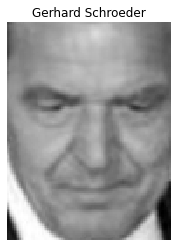

Модель перепутала с Jacques Chirac


In [53]:
plot_image(first_id)
plt.axis("off")
plt.show()
print(f"Модель перепутала с {names[first_false]}")

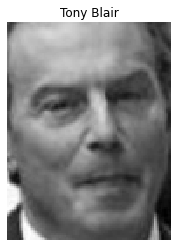

Модель перепутала с Donald Rumsfeld


In [54]:
plot_image(second_id)
plt.axis("off")
plt.show()
print(f"Модель перепутала с {names[second_false]}")

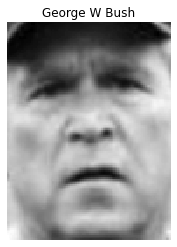

Модель перепутала с Guillermo Coria


In [55]:
plot_image(third_id)
plt.axis("off")
plt.show()
print(f"Модель перепутала с {names[third_false]}")